# Common geometric operations

Here we demonstrate some of the most common geometry manipulation functions available in `geopandas`. We will continue exploring the census tract data from Austin, Texas. It is often useful to do geometric manipulations on administrative borders for further analysis and visualization purposes. We will learn how to generate centroids, different outlines and buffer zones for the polygons.  

In [1]:
import os

os.environ["USE_PYGEOS"] = "0"

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
from pathlib import Path

In [3]:
# Define path do the data
data_folder = Path("data/Austin")
fp = data_folder / "austin_pop_density_2019.gpkg"

# Read in the data and check the contents
data = gpd.read_file(fp)
data.head()

,pop2019,tract,area_km2,pop_density_km2,geometry
0,6070.0,002422,4.029772,1506.288769,"POLYGON ((615643.487 3338728.496, 615645.477 3..."
1,2203.0,001751,1.532030,1437.961408,"POLYGON ((618576.586 3359381.053, 618614.330 3..."
2,7419.0,002411,3.960344,1873.322183,"POLYGON ((619200.163 3341784.654, 619270.849 3..."
3,4229.0,000401,2.181762,1938.341868,"POLYGON ((621623.757 3350508.165, 621656.294 3..."
4,4589.0,002313,2.431208,1887.538655,"POLYGON ((621630.247 3345130.744, 621717.926 3..."


For the purposes of geometric manipulations, we are mainly interested in the geometry column which contains the polygon geometries. Remember, that the data type of the geometry-column is `GeoSeries`. Individual geometries are eventually `shapely` objects and we can use all of `shapely`'s tools for geometry manipulation directly via `geopandas`.

In [4]:
# Check contents of the geometry column
data["geometry"].head()

0    POLYGON ((615643.487 3338728.496, 615645.477 3...
1    POLYGON ((618576.586 3359381.053, 618614.330 3...
2    POLYGON ((619200.163 3341784.654, 619270.849 3...
3    POLYGON ((621623.757 3350508.165, 621656.294 3...
4    POLYGON ((621630.247 3345130.744, 621717.926 3...
Name: geometry, dtype: geometry

In [5]:
# Check data type of the geometry column
type(data["geometry"])

geopandas.geoseries.GeoSeries

In [6]:
# Check data type of a value in the geometry column
type(data["geometry"].values[0])

shapely.geometry.polygon.Polygon

Let's first plot the original geometries. We can use the in-built plotting function in `geopandas` to plot the geometries, and `matplotlib.pyplot` to turn off axis lines and labels.

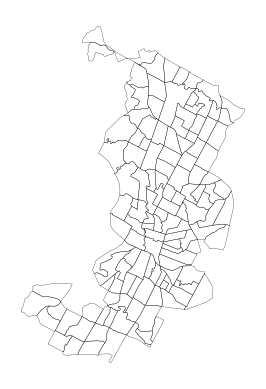

In [7]:
data.plot(facecolor="none", linewidth=0.2)

plt.axis("off")
plt.show()

_**Figure 6.13**. Basic plot of the census tracts._

## Centroid

Extracting the centroid of geometric features is useful in many cases. Geometric centroid can, for example, be used for locating text labels in visualizations. We can extract the center point of each polygon via the `centroid`-attribute of the geometry-column. The data should be in a projected coordinate reference system when calculating the centroids. If trying to calculate centroids based on latitude and longitude information, `geopandas` will warn us that the results are likely incorrect. Our sample data are in WGS 84 / UTM zone 14N (EPSG:32614), which is a projected , and we can proceed to calculating the centroids.

In [8]:
data.crs.name

'WGS 84 / UTM zone 14N'

In [9]:
data["geometry"].centroid.head()

0    POINT (616990.190 3339736.002)
1    POINT (619378.303 3359650.002)
2    POINT (620418.753 3342194.171)
3    POINT (622613.506 3351414.386)
4    POINT (622605.359 3343869.554)
dtype: geometry

We can also apply the method directly to the `GeoDataFrame` to achieve the same result using the syntax `data.centroid`. At the same time, we can also  plot the centroids for a visual check.

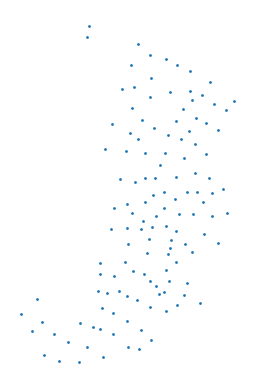

In [10]:
data.centroid.plot(markersize=1)

plt.axis("off")
plt.show()

_**Figure 6.14**. Basic plot of census tract centroids._

## Unary union

We can generate a joint outline for the administrative areas through creating a geometric union among all geometries. This could be useful, for example, for visualizing the outlines of a study area. The `unary_union` returns a single geometry object, which is automatically visualized when running the code in a Jupyter Notebook.

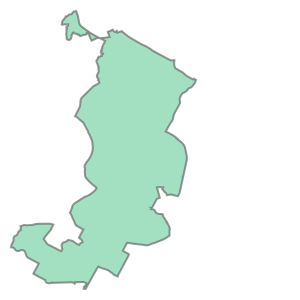

In [11]:
data.unary_union

_**Figure 6.15**. Union of all of census tract polygon geometries._

## Simplifying geometries

Geometry simplification is a useful process especially when visualizing data that has very detailed geometry. With our sample data, we can generate simplified version of the outline extent. The tolerance parameter controls the level of simplification.

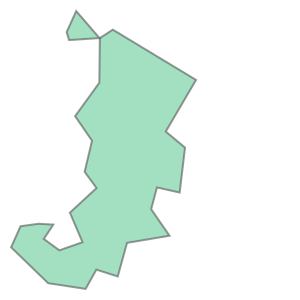

In [12]:
data.unary_union.simplify(tolerance=1000)

_**Figure 6.16**. Simplified union of the census tract polygons._

## Bounding polygon

Bounding polygons are useful in many cases for describing the approximate extent of geographic data. A minimum bounding rectangle, also called a bounding box or an envelope is the smallest rectangular polygon surrounding a geometric object. In a `GeoDataFrame`, the `envelope` attribute returns the bounding rectangle for each geometry.

In [13]:
data.envelope.head()

0    POLYGON ((615643.487 3337909.895, 618358.033 3...
1    POLYGON ((618529.497 3358797.000, 620192.632 3...
2    POLYGON ((619198.456 3340875.421, 621733.880 3...
3    POLYGON ((621599.087 3350329.320, 623714.366 3...
4    POLYGON ((621630.247 3343015.679, 624133.189 3...
dtype: geometry

In order to get the bounding rectangle for the whole layer, we  first create an union of all geometries using `unary_union`, and then create the bounding rectangle for that polygon.

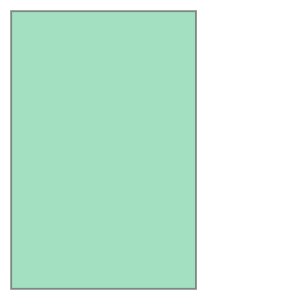

In [14]:
data.unary_union.envelope

_**Figure 6.17**. Minimum bounding box for the census tracts._

Corner coordinates of the bounding box for a `GeoDataFrame` can be fetched via the `total_bounds` attribute. 

In [15]:
data.total_bounds

array([ 608125.39434001, 3337909.89495403,  629828.38846075,
       3370513.6825782 ])

The `bounds` attribute returns the bounding coordinates of each feature.

In [16]:
data.bounds.head()

,minx,miny,maxx,maxy
0,615643.487492,3.337910e+06,618358.032738,3.341257e+06
1,618529.497100,3.358797e+06,620192.631882,3.360614e+06
2,619198.455980,3.340875e+06,621733.879615,3.343443e+06
3,621599.086586,3.350329e+06,623714.365506,3.352436e+06
4,621630.247042,3.343016e+06,624133.188692,3.345131e+06


### Convex hull

A bit more detailed delineation of the data extent can be extracted using a convex hull which represents the smalles possible polygon that contains all points in an object. If we apply the convex hull method on the whole `GeoDataFrame`, we will get a GeoSeries containing a convex hull for each polygon separately.

In [17]:
data.convex_hull.head()

0    POLYGON ((616870.883 3337909.895, 616852.964 3...
1    POLYGON ((619496.705 3358797.000, 618962.703 3...
2    POLYGON ((619848.500 3340875.421, 619811.394 3...
3    POLYGON ((622145.426 3350329.320, 622132.429 3...
4    POLYGON ((623931.770 3343015.679, 622426.307 3...
dtype: geometry

In order to create a covex hull for the whole extent, we need to first create an union of all polygons. 

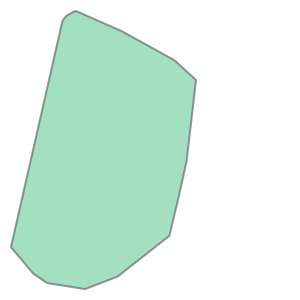

In [18]:
data.unary_union.convex_hull

_**Figure 6.18**. Smallest convex polygon for the census tracts._

## Buffer

Buffering is a common spatial operation that has a multitude of use cases in spatial analyses. For example, in transport network analyses, it is good to fetch the transport network also from outside the study area in order to capture routes that go beyond the study area border. The distance parameter in the `buffer` function defines the radius or the buffer (according to the coordinate reference system of the data). Applying the buffer function on the entire data frame will produce separate buffers for each census tract.

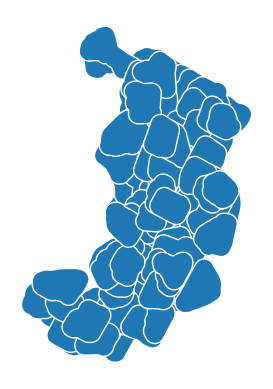

In [19]:
# 1000 m buffer for each polygon
data.buffer(1000).plot(edgecolor="white")

plt.axis("off")
plt.show()

_**Figure 6.19**. 1km buffer for each census tract._

If we want one buffer for the whole area, we first need to combine the geometries into one object before the buffer analysis. 

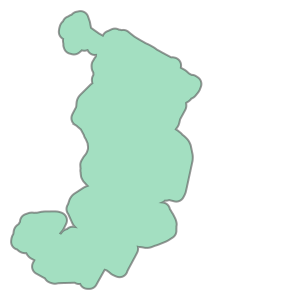

In [20]:
# 1000 m buffer for each polygon
data.unary_union.buffer(1000)

_**Figure 6.20**. 1km buffer for each census tract._

## Dissolving and merging geometries

Spatial data aggregation refers to combining geometries into coarser spatial units based on some attributes. The process may also include the calculation of summary statistics. 

In `pandas`, we learned how to group and aggregate data using the `groupby`method. In `geopandas`, there is a function called `dissolve()` that groups the data based on an anttribute column and unions the geometries for each group in that attribute. At the same time, we can also get summary statistics of the attributes. Read more about the details of the dissolve-function and related aggregation options in the `geopandas` [online documentation](https://geopandas.org/en/stable/docs/user_guide/aggregation_with_dissolve.html) [^gpd_dissolve].

To exceplify how dissolve works with our sample data, let's create create a new column to indicate census tracts with above average population density. We can do this by adding a new empty column `dense` and adding values that indicate above and below average population densities per census tract.

In [21]:
# Create a new column and add a constant value
data["dense"] = 0

In [22]:
# Filter rows with above average pop density and update the column dense
data.loc[data["pop_density_km2"] > data["pop_density_km2"].mean(), "dense"] = 1

In [23]:
# Check number of rows per category
data.dense.value_counts()

0    86
1    44
Name: dense, dtype: int64

Now we have a new column with value 1 indicating above average population density which we can use for dissolving the data into two groups using the `.dissolve()` funcition. At the same time, we can sum up the population and area columns valuens using the `aggfunc` parameter. The aggregation requires that we do a selection of the numerical columns we want to include in the output.

In [24]:
# Conduct the aggregation
dissolved = data[["pop2019", "area_km2", "dense", "geometry"]].dissolve(
    by="dense", aggfunc="sum"
)

In [25]:
# Check the result
dissolved

,geometry,pop2019,area_km2
dense,,,
0,"MULTIPOLYGON (((614108.230 3339640.551, 614288...",368992.0,231.131494
1,"MULTIPOLYGON (((612263.531 3338931.800, 612265...",242943.0,71.234570


The dissolved data should have as many rows of data as there were unique values in the column - one row for each unique value. Our data have been compressed into two geometric objects and the column used for dissolving the data can now be found in the index. Attribute columns represent the sum of the values per group. We can reset the index and insert the categorical information into a new column after which we can do a quick visualization of the result.

In [26]:
dissolved = dissolved.reset_index()

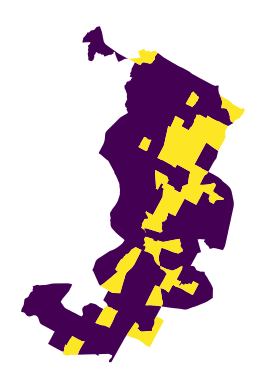

In [27]:
dissolved.plot(column="dense")

plt.axis("off")
plt.show()

_**Figure 6.21**. Dissolved census tract geometries._

## Footnotes

[^gpd_dissolve]: <https://geopandas.org/en/stable/docs/user_guide/aggregation_with_dissolve.html>